In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

from keras.callbacks import EarlyStopping

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [64]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)

# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(-1, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(-1, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [126]:
# convert all data 

from keras.preprocessing.sequence import TimeseriesGenerator

lookback = 3
num_features = len(train_lstm_df_dict_scaled[1].columns)

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)



# LSTM Model on Keras example on district 1

In [127]:
model = Sequential()
model.add(
    Masking(
        mask_value=0.,
        input_shape=(
            lookback,
            num_features,
        ),
    )
)
model.add(LSTM(units=50, activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit_generator(
    train_lstm_dataset_dict[1],
    epochs=10,
    verbose=1,
)



Epoch 1/10


/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_56498/1683472848.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
2023-04-02 22:59:05.160987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 3s 48ms/step - loss: 0.6161
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.5506
Epoch 3/10
36/36 [==============================] - 2s 42ms/step - loss: 0.5485
Epoch 4/10
36/36 [==============================] - 2s 42ms/step - loss: 0.5501
Epoch 5/10
36/36 [==============================] - 2s 45ms/step - loss: 0.5483
Epoch 6/10
36/36 [==============================] - 1s 41ms/step - loss: 0.5433
Epoch 7/10
36/36 [==============================] - 1s 41ms/step - loss: 0.5468
Epoch 8/10
36/36 [==============================] - 2s 42ms/step - loss: 0.5459
Epoch 9/10
36/36 [==============================] - 1s 41ms/step - loss: 0.5415
Epoch 10/10
36/36 [==============================] - 2s 43ms/step - loss: 0.5446


## Get predictions and plot

In [138]:
# get the predictions
predictions = model.predict(test_lstm_dataset_dict[1])

print(predictions.shape) # number of predictions is 3 less than the number of test data

# pad the predictions with 0 
predictions_padded = np.zeros((test_lstm_df_dict_scaled[1].shape[0], num_features)) # create array of zeros with the same shape as the test data
print(predictions_padded.shape)
predictions_padded[lookback:, 0] = predictions[:, 0] # fill the first column with the predictions
print(predictions_padded.shape)
# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded)


21/21 [==============================] - 0s 10ms/step
(21, 1)
(24, 9)
(24, 9)


In [136]:
print(test_lstm_df_dict_scaled[1].shape)
print(predictions_inversed.shape)

(24, 9)
(24, 9)


In [219]:
def evaluate_lstm(model, train_set, test_set):
    # make predictions
    train_predict = model.predict(train_set)
    test_predict = model.predict(test_set)

    # pad the predictions
    train_predict_padded = np.zeros((train_lstm_df_dict[1].shape[0], num_features))
    train_predict_padded[lookback:, 0] = train_predict[:, 0]
    test_predict_padded = np.zeros((test_lstm_df_dict[1].shape[0], num_features))
    test_predict_padded[lookback:, 0] = test_predict[:, 0]
    
    # inverse transform the predictions
    train_predict_inversed = scaler_dict[1].inverse_transform(train_predict_padded)
    test_predict_inversed = scaler_dict[1].inverse_transform(test_predict_padded)
    
    # calculate root mean squared error and ignore the first lookback values
    train_score = math.sqrt(mean_squared_error(train_lstm_df_dict[1]['resale_price'][lookback:], train_predict_inversed[lookback:, 0]))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(test_lstm_df_dict[1]['resale_price'][lookback:], test_predict_inversed[lookback:, 0]))
    print('Test Score: %.2f RMSE' % (test_score))

    # set index of the predictions to the index of the test data~
    train_predict_inversed = pd.DataFrame(train_predict_inversed, index=train_lstm_df_dict[1].index, columns=train_lstm_df_dict[1].columns)['resale_price']
    test_predict_inversed = pd.DataFrame(test_predict_inversed, index=test_lstm_df_dict[1].index, columns=test_lstm_df_dict[1].columns)['resale_price']

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[1]['resale_price'], label="train")
    plt.plot(test_lstm_df_dict[1]['resale_price'], label="test")
    plt.plot(train_predict_inversed, label="train_predict")
    plt.plot(test_predict_inversed, label="test_predict")
    plt.legend()
    plt.show()


21/21 [==============================] - 0s 9ms/step
Train Score: 209290.70 RMSE
Test Score: 247656.69 RMSE


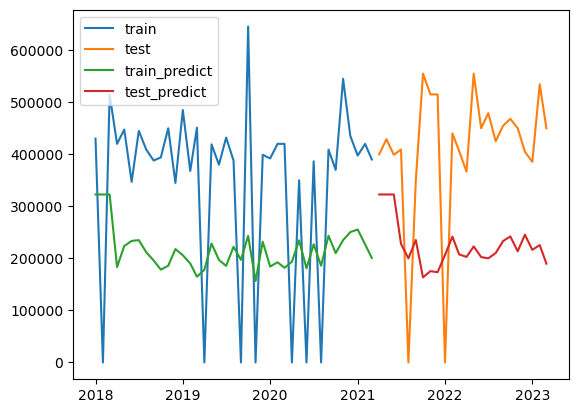

In [220]:
evaluate_lstm(model, train_lstm_dataset_dict[1], test_lstm_dataset_dict[1])